# MDI 720 : Statistiques
## Generalization
### *Joseph Salmon*

This notebook reproduces the pictures for the courses "Generalization_fr" / "Generalization_en"

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from os import mkdir, path
import statsmodels.formula.api as smf
from matplotlib import rc
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from scipy.interpolate import UnivariateSpline

In [2]:
dirname = "../prebuiltimages/"
if not path.exists(dirname):
    mkdir(dirname)

np.random.seed(seed=44)

###############################################################################
# Plot initialization

plt.close('all')
dirname = "../srcimages/"
imageformat = '.pdf'


rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
params = {'axes.labelsize': 12,
          'font.size': 16,
          'legend.fontsize': 16,
          'text.usetex': True,
          'figure.figsize': (8, 6)}
plt.rcParams.update(params)

sns.set_context("poster")
sns.set_palette("colorblind")
sns.set_style("white")
sns.axes_style()


###############################################################################
# display function:

saving = False


def my_saving_display(fig, dirname, filename, imageformat):
    """"Saving with personal function."""
    filename = filename.replace('.', 'pt')  # remove "." to avoid floats issues
    if saving is True:
        dirname + filename + imageformat
        image_name = dirname + filename + imageformat
        fig.savefig(image_name)

# Motivating example

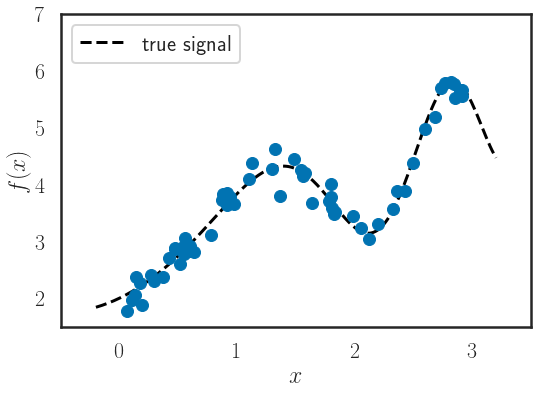

In [3]:
np.random.seed(seed=42)
n_samples = 60
sigma = 0.2  # noise level
x = np.sort(3. * np.random.rand(n_samples))
xx = np.linspace(-.2, 3.2, 200)


def f(x):
    return np.sin(x ** 2) + 2. + x


y = f(x)
y += sigma * np.random.randn(n_samples)

# Ploting Signal / Noise
fig = plt.figure(figsize=(8, 6))
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim([1.5, 7])
plt.xlim([-.5, 3.5])
plt.plot(xx, f(xx), '--k', label="true signal")
plt.legend(loc='upper left')
plt.tight_layout()
my_saving_display(fig, dirname, "sin_signal", imageformat)
plt.plot(x, y, 'o', label="noisy observations")
my_saving_display(fig, dirname, "sin_signal_noisy", imageformat)
plt.show()

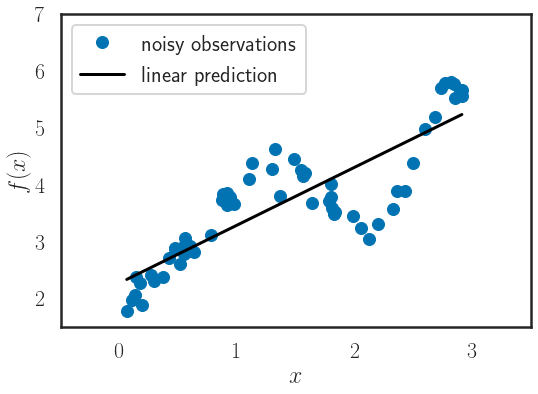

In [4]:
# Performing OLS
X = x[:, np.newaxis]
ols = LinearRegression(fit_intercept=True)
y_pred = ols.fit(X, y).predict(X)

# Plotting Signal / OLS
fig = plt.figure(figsize=(8, 6))
plt.plot(x, y, 'o', label="noisy observations")
plt.plot(X, y_pred, '-k', label="linear prediction")
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim([1.5, 7])
plt.xlim([-.5, 3.5])
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

my_saving_display(fig, dirname, "sin_signal_OLS", imageformat)

# Polynomial Regression

OLS coef
[2.27933767 0.99365503 0.00876502]
OLS coef
[ 1.10274056  5.6748322  -3.89572378  0.86254439]
OLS coef
[ 1.71887066  1.73868943  2.15892084 -2.36048027  0.547988  ]
OLS coef
[  2.5100627   -5.37269089  18.55515212 -16.95726575   6.05346875
  -0.73952439]
OLS coef
[  1.38595334   7.60140718 -22.5723281   37.28881048 -27.95762535
   9.32354027  -1.13036548]


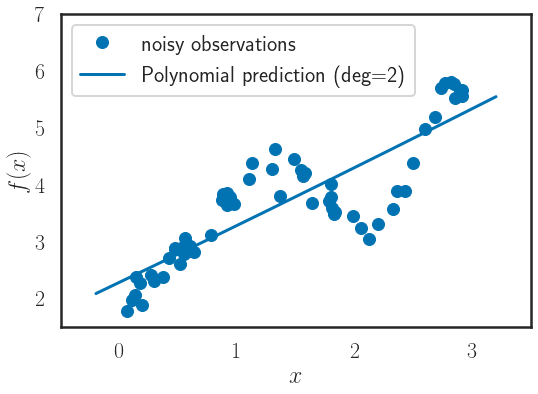

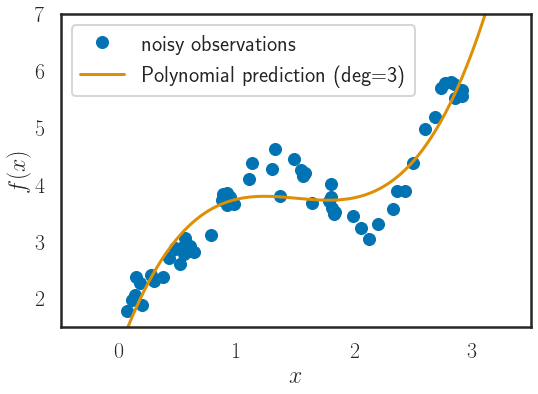

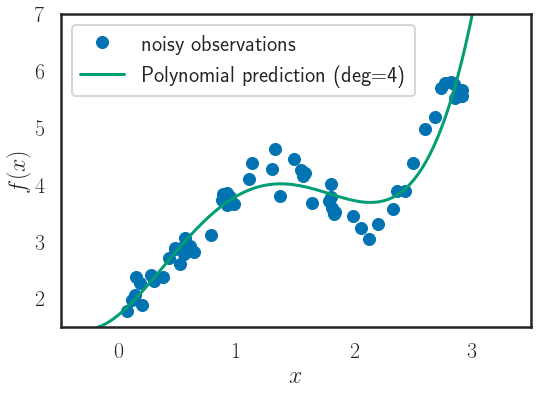

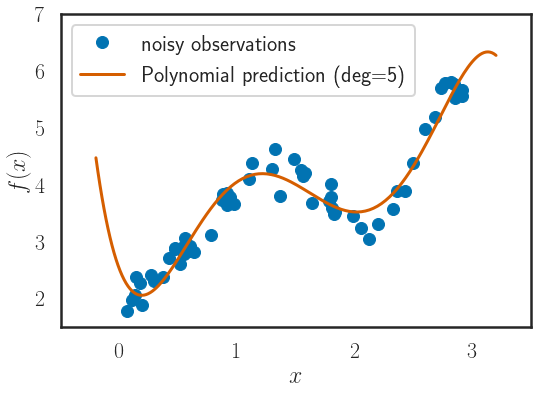

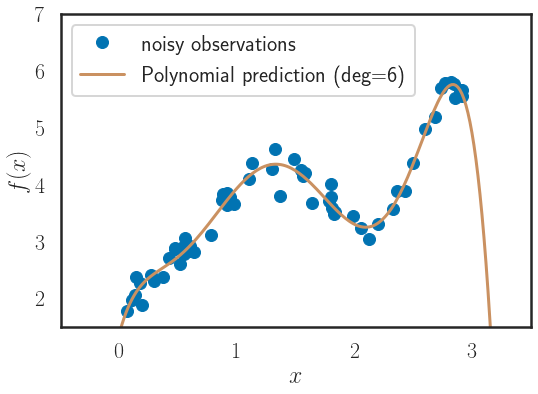

In [5]:
degrees = [2, 3, 4, 5, 6]
colors = [2, 3, 4, 5, 7]

for i, degree in enumerate(degrees):
    X_poly = np.vander(x, degree + 1, increasing=True)
    # Equivalent to:
    # X_poly = np.column_stack([x ** i for i in range(degree + 1)])
    ols = LinearRegression(fit_intercept=False)  # intercept already included!
    ols.fit(X_poly, y)
    y_pred = ols.predict(np.vander(xx, degree + 1, increasing=True))
    print("OLS coef")
    print(ols.coef_) # not the small coef on dim 2
    # Signal / OLS
    fig = plt.figure(figsize=(8, 6))
    plt.plot(x, y, 'o', label="noisy observations")
    plt.plot(xx, y_pred, '-',
             color=sns.color_palette("colorblind", 8)[colors[i] - 2],
             label=r"Polynomial prediction (deg={0})".format(degree))
    plt.xlabel('$x$')
    plt.ylabel('$f(x)$')
    plt.ylim([1.5, 7])
    plt.xlim([-.5, 3.5])
    plt.legend(loc='upper left')
    plt.tight_layout()
    my_saving_display(fig, dirname, "sin_signal_poly" + str(degree),
                      imageformat)
plt.show()

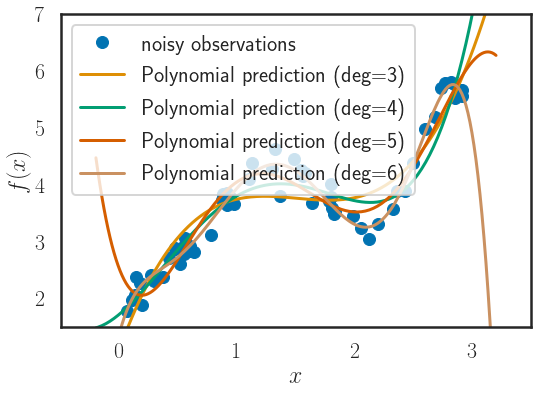

In [6]:
degrees = [3, 4, 5, 6]
colors = [3, 4, 5, 7]

fig2 = plt.figure(figsize=(8, 6))
plt.plot(x, y, 'o', label="noisy observations")
for i, degree in enumerate(degrees):
    X_poly = np.vander(x, degree + 1, increasing=True)
    ols = LinearRegression(fit_intercept=False)  # intercept already included!
    ols.fit(X_poly, y)
    y_pred = ols.predict(np.vander(xx, degree + 1, increasing=True))
    plt.plot(xx, y_pred, '-',
             color=sns.color_palette("colorblind", 8)[colors[i] - 2],
             label=r"Polynomial prediction (deg={0})".format(degree))
    plt.xlabel('$x$')
    plt.ylabel('$f(x)$')
    plt.ylim([1.5, 7])
    plt.xlim([-.5, 3.5])
    plt.legend(loc='upper left')
    plt.tight_layout()
plt.show()
my_saving_display(fig2, dirname, "sin_signal_poly_all", imageformat)

In [7]:
# defining a class for Polynonial Regression


class PolynomialRegression(LinearRegression):
    """PolynomialRegression Class, to perform for instance CV"""

    def __init__(self, degree=2):
        super(PolynomialRegression, self).__init__()
        self.degree = degree
        self.fit_intercept = False

    def fit(self, X, y, deg=None):
        X = np.vander(X, N=self.degree + 1)
        super(PolynomialRegression, self).fit(X, y)
        return self

    def predict(self, X):
        X = np.vander(X, N=self.degree + 1)
        return super(PolynomialRegression, self).predict(X)


model = PolynomialRegression(degree=3)

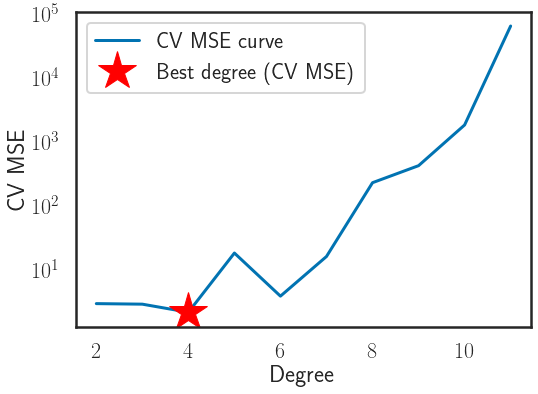

In [8]:
# On the importance of cross-validation

estimator = PolynomialRegression()
degrees = np.arange(2, 12)
cv_model = GridSearchCV(estimator, cv=5,
                        param_grid={'degree': degrees},
                        scoring='neg_mean_squared_error')
# Note: in scoring above, neg means -MSE
cv_model.fit(x, y)

mse = [-cv_score for cv_score in cv_model.cv_results_['mean_test_score']]
fig = plt.figure(figsize=(8, 6))
plt.semilogy(degrees, mse, label="CV MSE curve")
plt.xlabel('Degree')
plt.ylabel('CV MSE')
plt.legend(loc='upper left')
plt.tight_layout()

my_saving_display(fig2, dirname, "CV_curve", imageformat)

best_idx = np.argmax(cv_model.cv_results_['mean_test_score'])
best_deg = degrees[best_idx]
best_mse = -cv_model.cv_results_['mean_test_score'][best_idx]
plt.plot(best_deg, best_mse, "*r", markersize=40, label="Best degree (CV MSE)")
plt.legend(loc="upper left")
plt.tight_layout()

my_saving_display(fig2, dirname, "CV_curve_and_best", imageformat)
plt.show()


# alternatively, onec can do it directly with sklearn:

model = make_pipeline(PolynomialFeatures(degree=6), LinearRegression())
y_pred = model.fit(x[:, np.newaxis], y).predict(xx[:, np.newaxis])

# SPLINE PART :
Beware sicpy needs the points to be in ascending order!!!

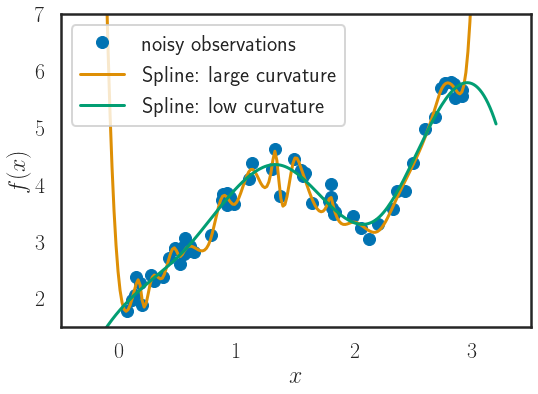

In [9]:
# Follow guidelines from:
# http://danielhnyk.cz/creating-your-own-estimator-scikit-learn/
# for creating an sklearn compatible class


class UnivariateSplineSmoother(LinearRegression):
    def __init__(self, s=4.):
        self.s = s

    def fit(self, x, y):
        self._spline = UnivariateSpline(x, y, s=self.s)
        return self

    def predict(self, x):
        return self._spline(x)


# large curvature means s is small
spline_smoother = UnivariateSplineSmoother(0.5).fit(x, y)
y_pred = spline_smoother.predict(xx)

# low curvature means s is large
spline_smoother = UnivariateSplineSmoother(2.).fit(x, y)
y_pred_bis = spline_smoother.predict(xx)

# Plotting Splines
fig = plt.figure(figsize=(8, 6))
plt.plot(x, y, 'o', label="noisy observations")
plt.plot(xx, y_pred, '-', label="Spline: large curvature")
plt.plot(xx, y_pred_bis, '-', label="Spline: low curvature")
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim([1.5, 7])
plt.xlim([-.5, 3.5])
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()
my_saving_display(fig, dirname, "splines", imageformat)

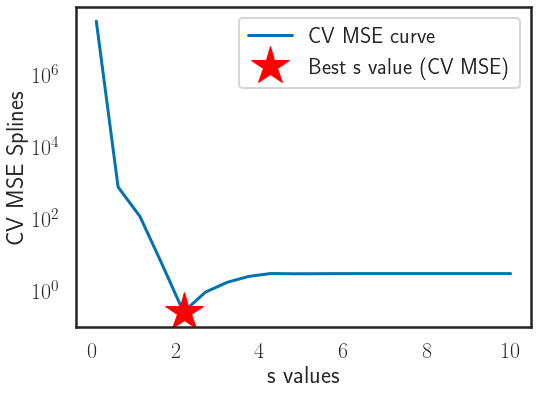

In [10]:
estimator = UnivariateSplineSmoother()
s_values = np.linspace(0.1, 10, num=20)
cv_model_spl = GridSearchCV(estimator, cv=5,
                            param_grid={'s': s_values},
                            scoring='neg_mean_squared_error')
# Note: in scoring above, "neg_mean_squared_error" means -MSE
cv_model_spl.fit(x, y)

mse_spl = [-cv_score for cv_score in cv_model_spl.cv_results_['mean_test_score']]
fig = plt.figure(figsize=(8, 6))
plt.semilogy(s_values, mse_spl, label="CV MSE curve")
plt.xlabel('s values')
plt.ylabel('CV MSE Splines')
plt.legend()
plt.tight_layout()
my_saving_display(fig, dirname, "CV_curve_spline", imageformat)


best_idx_spline = np.argmax(cv_model_spl.cv_results_['mean_test_score'])
best_s_spline = s_values[best_idx_spline]
best_mse_spline = -cv_model_spl.cv_results_['mean_test_score'][best_idx_spline]
plt.plot(best_s_spline, best_mse_spline, "*r", markersize=40,
         label="Best s value (CV MSE)")
plt.legend()
plt.tight_layout()
plt.show()
my_saving_display(fig, dirname, "CV_curve_and_best_spline", imageformat)

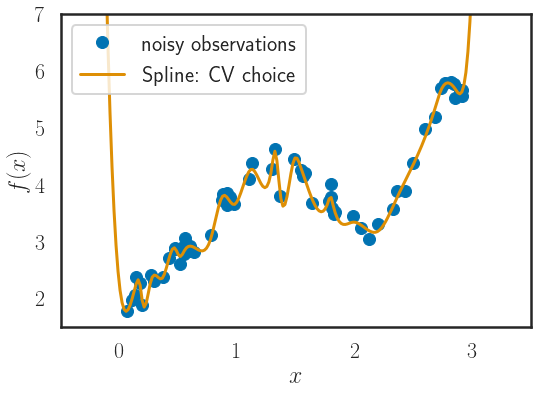

MSE Polynomials = 2.1899671188676364)
MSE Spline = 0.24984386133649528)


In [11]:
# large curvature means s is large
y_pred_bis = cv_model_spl.predict(xx)

# Plotting Splines
fig = plt.figure(figsize=(8, 6))
plt.plot(x, y, 'o', label="noisy observations")
plt.plot(xx, y_pred, '-', label="Spline: CV choice")
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim([1.5, 7])
plt.xlim([-.5, 3.5])
plt.legend(loc='upper left')
plt.tight_layout()
my_saving_display(fig, dirname, "best_spline_display", imageformat)
plt.show()

print("MSE Polynomials = {0})".format(best_mse))
print("MSE Spline = {0})".format(best_mse_spline))

# GAM PART

In [12]:
class GeneralizedAdditiveRegressor(LinearRegression):
    """Fit Generalized Additive Model with backfitting"""

    def __init__(self, smoothers, max_iter=20):
        self.smoothers = smoothers
        self.max_iter = max_iter

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.y_mean_ = np.mean(y)

        residuals = y.copy()
        residuals -= self.y_mean_
        for i in range(self.max_iter):
            for j in range(n_features):
                if i > 0:
                    residuals += self.smoothers[j].predict(X[:, j])

                self.smoothers[j].fit(X[:, j], residuals)
                residuals -= self.smoothers[j].predict(X[:, j])
        return self

    def predict(self, X):
        n_samples, n_features = X.shape
        y = np.ones(n_samples) * self.y_mean_
        for j in range(n_features):
            y += self.smoothers[j].predict(X[:, j])
        return y


def f1(x):
    return np.cos(3 * x)


def f2(x):
    return x ** 3


def f3(x):
    return 3 * np.log(1 + np.abs(x))


def f_true(X):
    return f1(X[:, 0]) + f2(X[:, 1]) + f3(X[:, 2])


n_samples = 100

x1 = np.sort(2. * np.random.rand(n_samples) - 1.)
x2 = np.sort(2. * np.random.rand(n_samples) - 1.)
x3 = np.sort(2. * np.random.rand(n_samples) - 1.)

X = np.c_[x1, x2, x3]
y = f_true(X)
y += 0.1 * np.random.randn(n_samples)


s1 = 10 * np.var(y)
s2 = 10 * np.var(y)
s3 = 10 * np.var(y)
smoothers = [UnivariateSplineSmoother(s=s1), UnivariateSplineSmoother(s=s2),
             UnivariateSplineSmoother(s=s3)]
gam = GeneralizedAdditiveRegressor(smoothers, max_iter=200)
gam.fit(X, y)
y_pred = gam.predict(X)

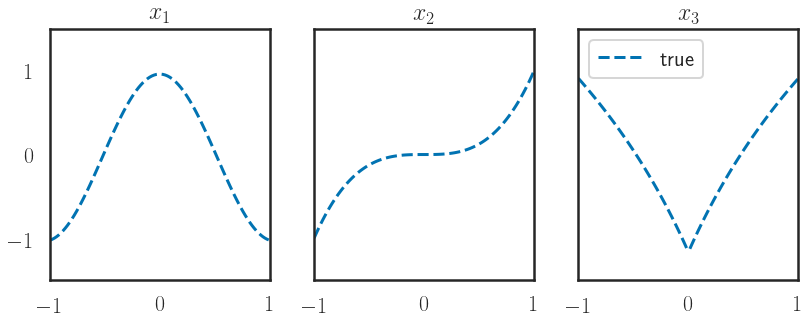

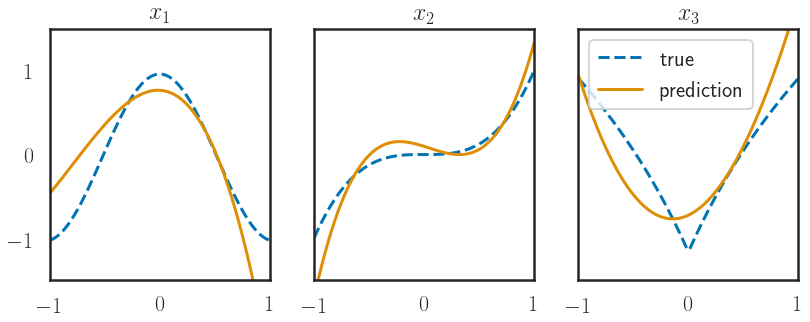

In [13]:
xx = np.linspace(-1, 1, 100)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 5),
                         sharex=True, sharey=True)

for j, (smoother, ax, f) in enumerate(zip(smoothers, axes.flat, [f1, f2, f3])):
    f_j = smoother.predict(xx)
    ax.plot(xx, f(xx) - np.mean(f(xx)), "--", label="true")
    ax.set_title("$x_{0}$".format(j + 1))
plt.ylim([-1.5, 1.5])
plt.xlim([-1., 1])
plt.tight_layout()
plt.legend(loc="upper left")
plt.show()
my_saving_display(fig, dirname, "GAM-true", imageformat)


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 5),
                         sharex=True, sharey=True)
for j, (smoother, ax, f) in enumerate(zip(smoothers, axes.flat, [f1, f2, f3])):
    f_j = smoother.predict(xx)
    ax.plot(xx, f(xx) - np.mean(f(xx)), "--", label="true")
    ax.plot(xx, f_j - np.mean(f_j), label="prediction")
    plt.ylim([-1.5, 1.5])
    plt.xlim([-1., 1])
    ax.set_title("$x_{0}$".format(j + 1))
plt.tight_layout()
plt.legend(loc="upper left")
plt.show()
my_saving_display(fig, dirname, "GAM-true-predict", imageformat)

# Robustness PART

In [14]:
np.random.seed(seed=42)
n_samples = 60
sigma = 0.2  # noise level
x = np.sort(3. * np.random.rand(n_samples))
xx = np.linspace(-.2, 3.2, 200)

y = 3 * x
espilon = 5 * np.random.randn(n_samples)
espilon[1] = 70
espilon[2] = 50
espilon[3] = 45
espilon[5] = 48

y += espilon

# Performing OLS
X = x[:, np.newaxis]
ols = LinearRegression(fit_intercept=True)
y_pred = ols.fit(X, y).predict(X)

/home/jo/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/jo/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


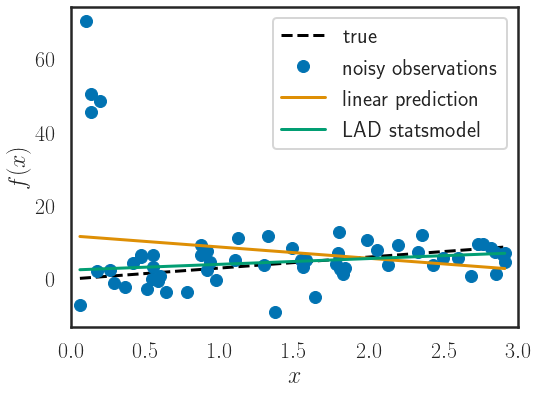

In [15]:
d = {'temp': x, 'dens': y}
df = pd.DataFrame(data=d)
mod = smf.quantreg('dens ~ temp', df)
res = mod.fit(q=.5)

# Plotting Signal / OLS
fig = plt.figure(figsize=(8, 6))
plt.plot(X, 3 * X, '--k', label="true")
plt.plot(X, y, 'o', label="noisy observations")
plt.plot(X, y_pred, '-', label="linear prediction")
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.xlim([0, 3])
plt.legend(loc='upper right')
plt.tight_layout()
my_saving_display(fig, dirname, "robust_ols", imageformat)

plt.plot(x, res.predict({'temp': x}), linestyle='-',
         label='LAD statsmodel', zorder=2)
plt.xlim([0, 3])
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
my_saving_display(fig, dirname, "robust_lad", imageformat)